# Import Dependencies

In [136]:
import importlib
import os
from pathlib import Path

import numpy as np
import pandas as pd

import config
import module
from tests import test

for p in [config, module, test]:
    try:
        importlib.reload(p)  # reload module
    except NameError:
        pass

# Load DF


In [56]:
# load DFs
df_att = pd.read_excel(config.path_attendance_data)
df_sess = pd.read_excel(config.path_session_data)
df_trainer = pd.read_excel(config.path_trainer_data, sheet_name=config.month)
df_noncoco = pd.read_excel(config.path_noncoco)
df_coco_member = pd.read_excel(config.path_coco_member)
df_erwin_member = pd.read_excel(config.path_erwin_member)

# Clean and Merge DF


In [57]:
# add data source column to df_sess and df noncoco
# drop index column
# sort column alphabetically
df_sess = (
    df_sess.assign(data_source="coco")
    .drop(columns="index", errors="ignore")
    .loc[:, lambda df_: sorted(df_.columns)]
)
df_noncoco = (
    df_noncoco.assign(data_source="noncoco")
    .drop(columns="index", errors="ignore")
    .loc[:, lambda df_: sorted(df_.columns)]
)

# merge df session and df noncoco
df_sess_full = (
    pd.concat([df_sess, df_noncoco], axis=0)
    .reset_index(drop=True)
    .assign(index=lambda df_: df_.index + 1)
    .assign(
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping),
    )
)
df_sess_full.shape

(5266, 21)

## Test


In [58]:
test.test_noncoco_online_class_is_online_location(df_noncoco)
test.test_coco_and_noncoco_cols_same(df_sess, df_noncoco)
test.test_class_exist_in_module_class_grouping(df_sess, "class_type_grouped")
test.test_class_exist_in_module_class_grouping(df_noncoco, "class_type_grouped")
test.test_teacher_center_area_position_not_null(
    df_sess_full, ["teacher_area", "teacher_center", "teacher_position"]
)
test.test_no_trainer_is_duplicated(df_trainer, "coco_teacher_name")
test.test_all_coco_student_centers_are_mapped_in_center_order(
    df_coco_member, "student_center"
)
test.test_all_erwin_student_centers_are_mapped_in_center_order(
    df_erwin_member, "center"
)
test.test_class_type_grouped_mapped_in_class_grouping(
    df_sess_full["class_type_grouped"]
)
test.test_duration_not_null(df_sess_full["class_duration"])

# 1: Class Session & util


In [59]:
class_session = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .groupby(["class_grouping", "class_mode", "class_type_grouped"])
    .agg(
        total_scheduled_session=("class_type_grouped", "size"),
        # count how many rows have status "Given"
        total_delivered_session=(
            "class_status", lambda c: (c == "Given").sum()),
        # use sum first because to obtain avg, have to divide sum by num of classes
        total_attendance=("class_attendance", "sum"),
    )
    .assign(
        max_attendance=lambda df_: df_.index.get_level_values(2).map(
            module.class_target
        ),
        avg_attendance=lambda df_: (df_["total_attendance"]
                                    .div(df_["total_delivered_session"])
                                    .astype(float)
                                    .round(1)
                                    .replace(0.0, np.nan)
                                    ),
        avg_per_max_attendance=lambda df_: (df_["avg_attendance"]
                                            .div(df_["max_attendance"])
                                            .round(2)
                                            ),
        percentage_delivered=lambda df_: (df_["total_delivered_session"]
                                          .div(df_["total_scheduled_session"])
                                          .astype(float)
                                          .round(2)
                                          ),
    )
    # sort index to place "Other" below
    .sort_index(level=0, ascending=False)
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["", "Class Mode", "Class Type Grouped"])
    .loc[
        :,
        [
            "Total Scheduled Session",
            "Total Delivered Session",
            "Percentage Delivered",
            "Max Attendance",
            "Avg Attendance",
            "Avg Per Max Attendance",
        ],
    ]
)

class_session

Total Scheduled Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                        144   
                    Online One-on-one                                 310   
         Offline    VPG                                                64   
                    One-on-one                                        399   
Standard Online     Online Social Club                                251   
                    Online First Lesson                                44   
                    Online Complementary                              334   
                    Online Community                                   33   
                    Online Advising Session                           161   
         Offline    Social Club                                       457   
                    Member's Party                                     17   
                    First Lesson                                      113   
                    Complementary                                     307   
                    Community                                          71   
                    Chat Hour                                         223   
                    Advising Session                                    4   
Other    Online     Online Proskill First Lesson                        1   
                    Online Proskill                                     5   
                    Online IELTS First Lesson                           1   
         Offline    Proskill First Lesson                               7   
                    Proskill                                           10   
                    Other                                             210   
                    Mock Test                                           3   
                    IELTS First Lesson                                 10   
                    IELTS                                              53   

                                                  Total Delivered Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                        116   
                    Online One-on-one                                 197   
         Offline    VPG                                                57   
                    One-on-one                                        314   
Standard Online     Online Social Club                                251   
                    Online First Lesson                                44   
                    Online Complementary                              322   
                    Online Community                                   33   
                    Online Advising Session                           120   
         Offline    Social Club                                       425   
                    Member's Party                                     17   
                    First Lesson                                      112   
                    Complementary                                     251   
                    Community                                          62   
                    Chat Hour                                         218   
                    Advising Session                                    4   
Other    Online     Online Proskill First Lesson                        1   
                    Online Proskill                                     5   
                    Online IELTS First Lesson                           1   
         Offline    Proskill First Lesson                               7   
                    Proskill                                           10   
                    Other                                             175   
                    Mock Test                                           3   
                    IELTS First Lesson       

## Test


In [60]:
test.test_all_classes_are_included(df_sess_full, class_session)

# 2: ET Utilization


In [61]:
et_excluded = []

et_util = (
    df_sess_full
    # merge with df trainer to get working days etc
    .merge(
        df_trainer, 
        how="left", 
        left_on="teacher",
        right_on="coco_teacher_name",
    )
    # ! exclude et if less than 1 month
    .loc[lambda df_: ~(df_['teacher'].isin(et_excluded))]
    # to calculate class duration for delivered only,
    # create a temp column
    # if given, leave, if not given, 0
    .assign(
        class_duration_delivered=lambda df_: np.where(
            df_["class_status"] == "Given", df_["class_duration"], 0
        )
    )
    .groupby(["teacher_position_y", "teacher_area_x", "teacher"])
    .agg(
        working_days=("teacher_working_days", "mean"),
        total_scheduled_hours=("class_duration", "sum"),
        total_delivered_hours=("class_duration_delivered", "sum"),
    )
    # filter only for ET and coach
    .loc[
        lambda df_: df_.index.get_level_values("teacher_position_y").isin(
            ["ET", "Coach"]
        )
    ]
    .assign(
        working_days=lambda df_: df_["working_days"].astype("Int64"),
        total_scheduled_hours=lambda df_: df_[
            "total_scheduled_hours"].astype(int),
        total_delivered_hours=lambda df_: df_[
            "total_delivered_hours"].astype(int),
        scheduled_hours_per_day=lambda df_: (
            df_["total_scheduled_hours"].div(df_["working_days"]).round(1)
        ),
        delivered_hours_per_day=lambda df_: (
            df_["total_delivered_hours"].div(df_["working_days"]).round(1)
        ),
        max_class_hours=lambda df_: module.create_max_hour_per_trainer(df_),
        scheduled_utilization=lambda df_: df_["scheduled_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
        delivered_utilization=lambda df_: df_["delivered_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Teacher Position", "Teacher Area", "Teacher"])
)
print(et_util.shape)
et_util.head()

(35, 8)


Working Days  \
Teacher Position Teacher Area Teacher                                    
Coach            BDG          Mustikawati Eka                       18   
                 JKT 1        Hamsah Handayani Ratnasari            18   
                              Mordechai Kaleb Arthur                19   
                              Oktavia Cindy                         17   
                              Rifani Aurora Nurhidayah              16   

                                                          Total Scheduled Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                               106   
                 JKT 1        Hamsah Handayani Ratnasari                    105   
                              Mordechai Kaleb Arthur                        104   
                              Oktavia Cindy                                  86   
                              Rifani Aurora Nurhidayah                       87   

                                                          Total Delivered Hours  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                                96   
                 JKT 1        Hamsah Handayani Ratnasari                     90   
                              Mordechai Kaleb Arthur                         82   
                              Oktavia Cindy                                  71   
                              Rifani Aurora Nurhidayah                       75   

                                                          Scheduled Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 5.9   
                 JKT 1        Hamsah Handayani Ratnasari                      5.8   
                              Mordechai Kaleb Arthur                          5.5   
                              Oktavia Cindy                                   5.1   
                              Rifani Aurora Nurhidayah                        5.4   

                                                          Delivered Hours Per Day  \
Teacher Position Teacher Area Teacher                                               
Coach            BDG          Mustikawati Eka                                 5.3   
                 JKT 1        Hamsah Handayani Ratnasari                      5.0   
                              Mordechai Kaleb Arthur                          4.3   
                              Oktavia Cindy                                   4.2   
                              Rifani Aurora Nurhidayah                        4.7   

                                                          Max Class Hours  \
Teacher Position Teacher Area Teacher                                       
Coach            BDG          Mustikawati Eka                         5.0   
                 JKT 1        Hamsah Handayani Ratnasari              5.0   
                              Mordechai Kaleb Arthur                  5.0   
                              Oktavia Cindy                           5.0   
                              Rifani Aurora Nurhidayah                5.0   

                                                          Scheduled Utilization  \
Teacher Position Teacher Area Teacher                                             
Coach            BDG          Mustikawati Eka                              1.18   
                 JKT 1        Hamsah Handayani Ratnasari                   1.16   
                              Mordechai Kaleb Arthur                        1.1   
                              Oktavia Cindy                                1.02   
                              Rifani Aurora Nurhidayah                     1.08   

                                                          Del

# 2: Ooolab


In [62]:
ooolab = (df_sess_full
          .loc[df_sess_full['teacher_center'] == 'Ooolab']
          .groupby(['class_service', 'class_mode', 'class_type_grouped', 'class_type'])
          .size()
          .to_frame()
          .rename(columns={0: 'count'})
          .rename(columns=lambda c: c.replace('_', ' ').title())
          .rename_axis(['Class Service', 'Class Mode', 'Class Type Grouped', 'Class Type'])
          )
ooolab

Count
Class Service Class Mode Class Type Grouped   Class Type                  
Deluxe & Go   Online     Online Complementary Online Complementary      76
                         Online Social Club   Online Social Club        54
VIP           Online     Online VPG           Online Complementary       1
                                              Online English Corner     67

# 4: Community


## Filter for Community Classes


In [63]:
df_comm = (
    df_sess_full
    # filter for community
    .loc[
        df_sess_full["class_type_grouped"].isin(["Online Community", "Community"])
    ].assign(
        # create com name
        community_name=lambda df_: module.create_com_class(df_["class_description"]),
        # create com class type
        community_class_type=lambda df_: module.create_com_class_type(
            df_["class_description"]
        ),
    )
)

## Community Report 1


In [64]:
df_comm_report = (
    df_comm
    .groupby(["community_name", "community_class_type", "class_mode"])
    .agg(
        total_scheduled_session=("community_class_type", "count"),
        total_delivered_session=(
            "class_status", lambda i: (i == "Given").sum()),
        total_attendance=("class_attendance", "sum"),
        avg_attendance=("class_attendance", "mean"),
    )
    .assign(
        avg_attendance=lambda df_: df_[
            "avg_attendance"].astype(float).round(1),
        percentage_delivered=lambda df_: df_["total_delivered_session"]
        .div(df_["total_scheduled_session"])
        .round(2),
    )[
        [
            "total_scheduled_session",
            "total_delivered_session",
            "percentage_delivered",
            "total_attendance",
            "avg_attendance",
        ]
    ]
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Community", "Class Type", "Class Mode"])
)
df_comm_report

Total Scheduled Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           9   
                     Online                            4   
Leap      Meet Up    Offline                          10   
                     Online                            4   
          Showcase   Offline                           1   
          Workshop   Offline                           8   
                     Online                            4   
Re-Charge Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           3   
                     Online                            4   
Syndicate Meet Up    Offline                           9   
                     Online                            3   
          Showcase   Offline                           1   
          Workshop   Offline                           7   
                     Online                            4   
UNNAMED   Other      Offline                           5   

                                 Total Delivered Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           8   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           9   
                     Online                            4   
Leap      Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Offline                           1   
          Workshop   Offline                           7   
                     Online                            4   
Re-Charge Meet Up    Offline                           8   
                     Online                            4   
          Showcase   Online                            1   
          Workshop   Offline                           3   
                     Online                            4   
Syndicate Meet Up    Offline                           9   
                     Online                            3   
          Showcase   Offline                           1   
          Workshop   Offline                           7   
                     Online                            4   
UNNAMED   Other      Offline                           0   

                                 Percentage Delivered  Total Attendance  \
Community Class Type Class Mode                                           
CRE-8     Meet Up    Offline                     0.89              22.0   
                     Online                      1.00              50.0   
          Showcase   Online                      1.00              34.0   
          Workshop   Offline                     1.00              46.0   
                     Online                      1.00              42.0   
Leap      Meet Up    Offline                     0.90              47.0   
                     Online                      1.00              52.0   
          Showcase   Offline                     1.00              14.0   
          Workshop   Offline                     0.88              37.0   
                     Online                      1.00              66.0   
Re-Charge Meet Up    Offline                     0.89              68.0   
                     Online                      1.00              37.0   
          Showcase   Online                      1.00              38.0   
          Workshop   Offline                     1.00              30.0   
                     Online                      1.00              66.0

## Community Report 2


Get the attendance for community classes only.


In [65]:
df_att_comm = (
    df_att
    # create community class type
    .assign(community_class_type=lambda df_: module.create_comm_class_for_att(df_))
    # filter for community
    .loc[lambda df_: df_["community_class_type"] != "NONE"]
    # filter for attendance
    .loc[lambda df_: df_["student_attendance"] == "Attend"]
)
df_att_comm

,class_area,class_date,class_description,class_duration,class_location,class_mode,class_time,class_type,coco_teacher_name,student_attendance,student_center,student_code,student_membership,teacher,teacher_area,teacher_center,teacher_position,index,community_class_type
2043,Online,2024-02-05,"online community re-charge meet up ""connect & ...",1,Online,Online,16:00,Online Social Club,Ansyahputri Anggita Rizkiarachma,Attend,Indonesia,ALPREDA (GO) SONYA MILENITA - 3760,GO,Ansyahputri Anggita Rizkiarachma,JKT 3,KK,Coach,2044,Online Community
2046,Online,2024-02-05,"online community re-charge meet up ""connect & ...",1,Online,Online,16:00,Online Social Club,Ansyahputri Anggita Rizkiarachma,Attend,Indonesia,APRIYANI (DLX PP) FITRI - 10868,Deluxe,Ansyahputri Anggita Rizkiarachma,JKT 3,KK,Coach,2047,Online Community
2055,Online,2024-02-05,"online community re-charge meet up ""connect & ...",1,Online,Online,16:00,Online Social Club,Ansyahputri Anggita Rizkiarachma,Attend,Indonesia,FITRI (DLX KK) IKA KEUMALA - 10250,Deluxe,Ansyahputri Anggita Rizkiarachma,JKT 3,KK,Coach,2056,Online Community
2058,Online,2024-02-05,"online community re-charge meet up ""connect & ...",1,Online,Online,16:00,Online Social Club,Ansyahputri Anggita Rizkiarachma,Attend,Indonesia,HAMIDI (GO) IDHAM - 3777,GO,Ansyahputri Anggita Rizkiarachma,JKT 3,KK,Coach,2059,Online Community
2061,Online,2024-02-05,"online community re-charge meet up ""connect & ...",1,Online,Online,16:00,Online Social Club,Ansyahputri Anggita Rizkiarachma,Attend,Indonesia,HUSNA (DLX PKW) ZUWIDATUL - 10640,Deluxe,Ansyahputri Anggita Rizkiarachma,JKT 3,KK,Coach,2062,Online Community
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14566,Online,2024-02-26,online community cre-8 showcase event: drawn t...,1,Online,Online,19:00,Online Social Club,Community Team,Attend,Indonesia,WAHYUDDIN (GO) KHANSA DZAHABIYYA - 4103,GO,Community Team,HO,HO,Community Team,14567,Online Community
14567,Online,2024-02-26,online community cre-8 showcase event: drawn t...,1,Online,Online,19:00,Online Social Club,Community Team,Attend,Indonesia,WIBOWO (DLX PKW) CAROLINE VIOLA - 10641,Deluxe,Community Team,HO,HO,Community Team,14568,Online Community
14571,Online,2024-02-26,online community cre-8 showcase event: drawn t...,1,Online,Online,19:00,Online Social Club,Community Team,Attend,Indonesia,WINATA (VIP) KARINA - 8597,VIP,Community Team,HO,HO,Community Team,14572,Online Community
14576,Online,2024-02-26,online community cre-8 showcase event: drawn t...,1,Online,Online,19:00,Online Social Club,Community Team,Attend,Indonesia,YUMNISARI (DLX DG) MAULIDA - 10252,Deluxe,Community Team,HO,HO,Community Team,14577,Online Community


Group.


In [66]:
def catchstate(df, var_name: str) -> 'pd.DataFrame':
    """
    Helper function that captures intermediate Dataframes mid-chain.
    In the global namespace, make a new variable called var_name and set it to dataframe
    """
    globals()[var_name] = df
    return df


df_comm_report_2 = (
    df_att_comm
    .groupby("student_code")
    .agg(num_class_attended=("student_code", "size"))
    .reset_index()
    .groupby("num_class_attended")
    .agg(num_members_who_join_x_class=("num_class_attended", "size"))
    .pipe(catchstate, "temp")
    .reindex(range(1, temp.index.max()+1))
    .fillna(0)
    .astype(int)
    .reset_index()
    .rename(columns=lambda c: c.replace("_", " ").title())
)
df_comm_report_2

,Num Class Attended,Num Members Who Join X Class
0,1,294
1,2,92
2,3,43
3,4,24
4,5,15
5,6,8
6,7,4
7,8,1
8,9,0
9,10,2


## Test


In [67]:
test.test_all_com_classes_are_included(df_sess_full, df_comm_report)
test.test_total_att_1_eq_total_att_2(df_comm_report, df_comm_report_2)

# 5: Member Cohort


## Load DFs


In [97]:
# create a date range from jan 2023 to current month
# create a date range from jan 2023 to current month in a readable format
date_ranges = module.create_eom_date_ranges("2023-01", config.month)
month_ranges = [i.strftime("%Y-%m").lower() for i in date_ranges]

# list of all att files
att_files = [
    f"{config.path_attendance_data_parent}/2023/{i}/data-attendance-{i}.xlsx"
    for i in month_ranges
]
att_files = att_files + [
    f"{config.path_attendance_data_parent}/2024/{i}/data-attendance-{i}.xlsx"
    for i in month_ranges
]

# get all att files and concat
dfs = []
cols_to_use = ["student_code", "class_date", "student_attendance"]
for file in att_files:
    try:
        dfs.append(pd.read_excel(file, usecols=cols_to_use))
    except FileNotFoundError:
        pass

df_att_all_mo = pd.concat(dfs, ignore_index=True)
print(len(date_ranges), len(dfs))

14 14


## Create Overall Cohort


In [100]:
cohort_start_date = (
    pd.to_datetime(config.month, format="%Y-%m")
    - pd.Timedelta(days=330)
    - pd.offsets.MonthBegin(1)  # make this the beginning of the month
)
cohort_end_date = (
    pd.to_datetime(config.month, format="%Y-%m")
    + pd.offsets.MonthEnd(0)  # make this the end of the month
)
print(f"cohort start :{cohort_start_date: '%d %b %Y'}, cohort end :{cohort_end_date: '%d %b %Y'}")

cohort start : '01 Mar 2023', cohort end : '29 Feb 2024'


In [105]:
# the date on which the member join
df_member_clean = (
    df_coco_member.rename(columns={"start_date": "date"}).assign(is_first=True)
    # loc date between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date),
        ["student_code", "date", "is_first"],
    ]
)

# attendance of all member
df_att_all_mo_clean = (
    df_att_all_mo.loc[lambda df_: df_[
        "student_attendance"] == "Attend"]  # only attend
    .drop(columns=["student_attendance"])
    .rename(columns={"class_date": "date"})
    # loc attendance between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_date)
        & (df_["date"] <= cohort_end_date)
    ]
    # only include members who are in df_member_clean
    # else, old members who started before that will be in the data
    .loc[lambda df_: df_["student_code"].isin(
        df_member_clean["student_code"].unique()
    )]
)

# concat att and member
df_cohort_raw = (
    pd.concat([df_member_clean, df_att_all_mo_clean])
    # drop the same date
    .sort_values(["is_first", "date"])
    .drop_duplicates(subset=["student_code", "date"], keep="first")
    .drop(columns=["is_first"])
    .assign(date=lambda df_: pd.to_datetime(df_["date"]))
    .rename(columns={
        "student_code": "customer_id",
        "date": "transaction_date"
    })
)

# note: somehow, there are members who started lesson before contract start
# for now, no time to check
# last time checked, there are 125 members
# which is about 3 percent (negligible)

def get_members_study_before_contract_start():
    return (
        df_cohort_raw
        .fillna(False)
        .assign(is_first=lambda df_: df_["is_first"].astype(str))
        .groupby(["customer_id", "is_first"])
        ["transaction_date"].min()
        .to_frame()
        .reset_index()
        .pivot(index="customer_id", columns="is_first")
        .reset_index()
        .droplevel(0, axis="columns")
        .loc[
            lambda df_: df_["True"] > df_["False"]
        ]
    )

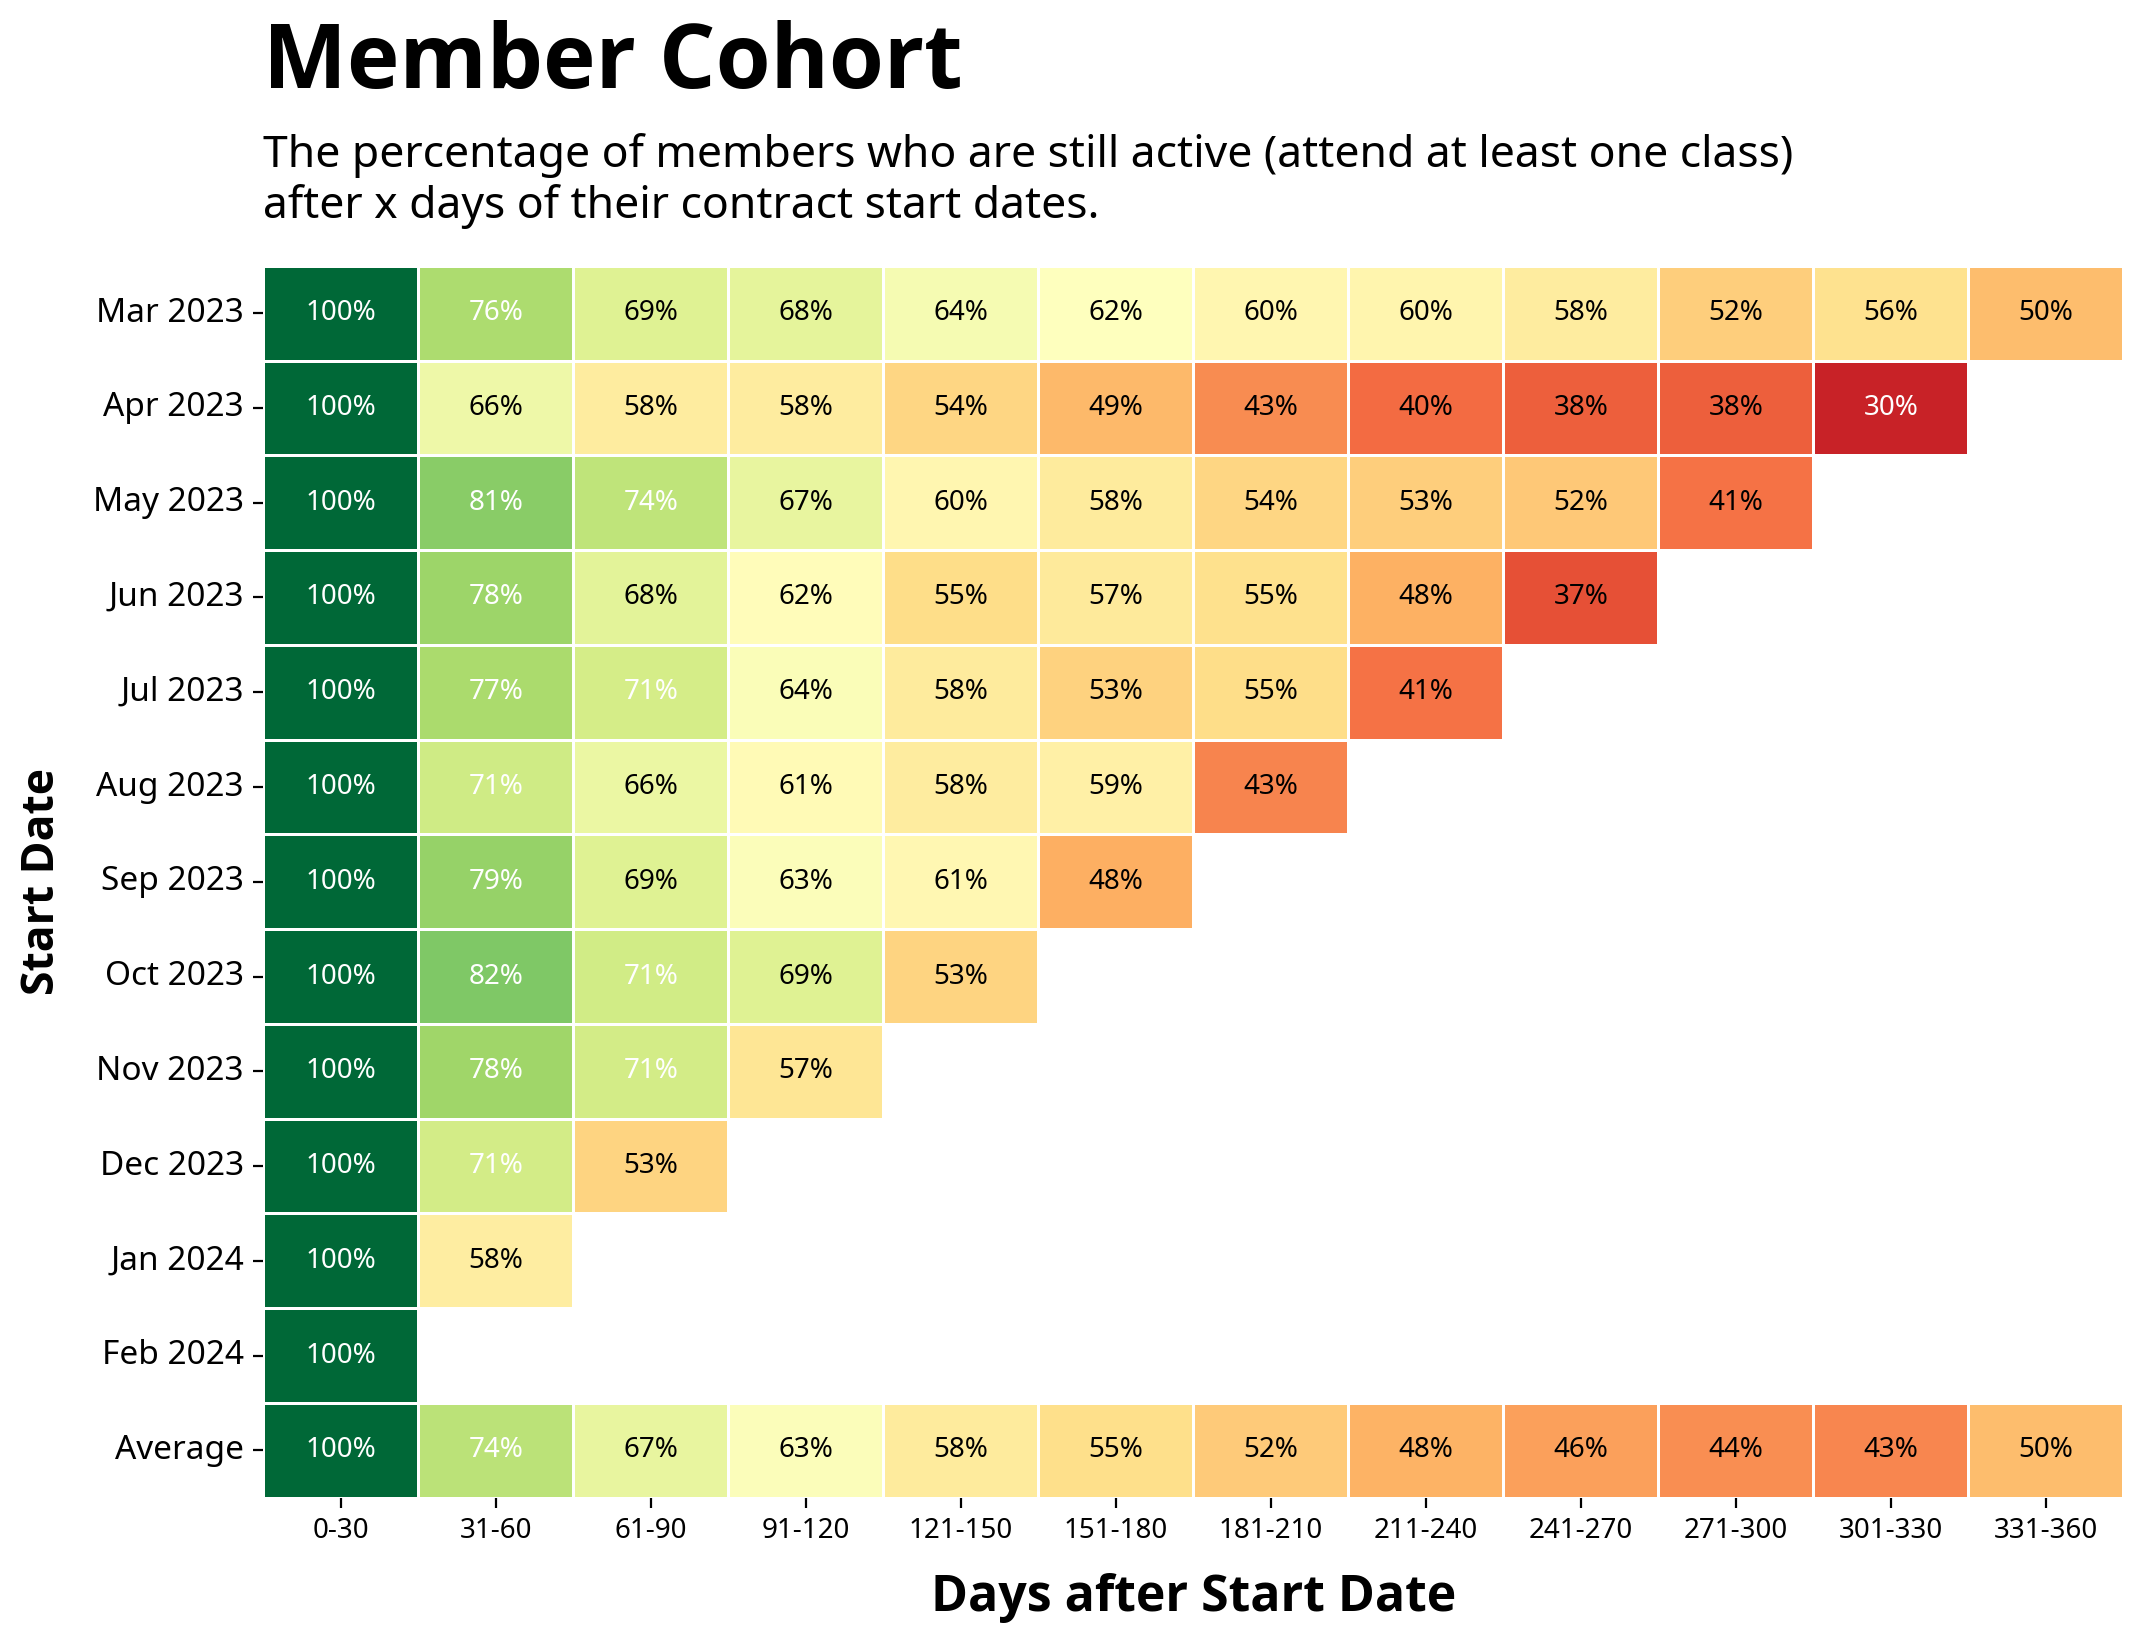

In [114]:
df_cohort = module.make_cohort(df_cohort_raw)
module.plot_cohort(df_cohort)

## Create Cohort per Membership

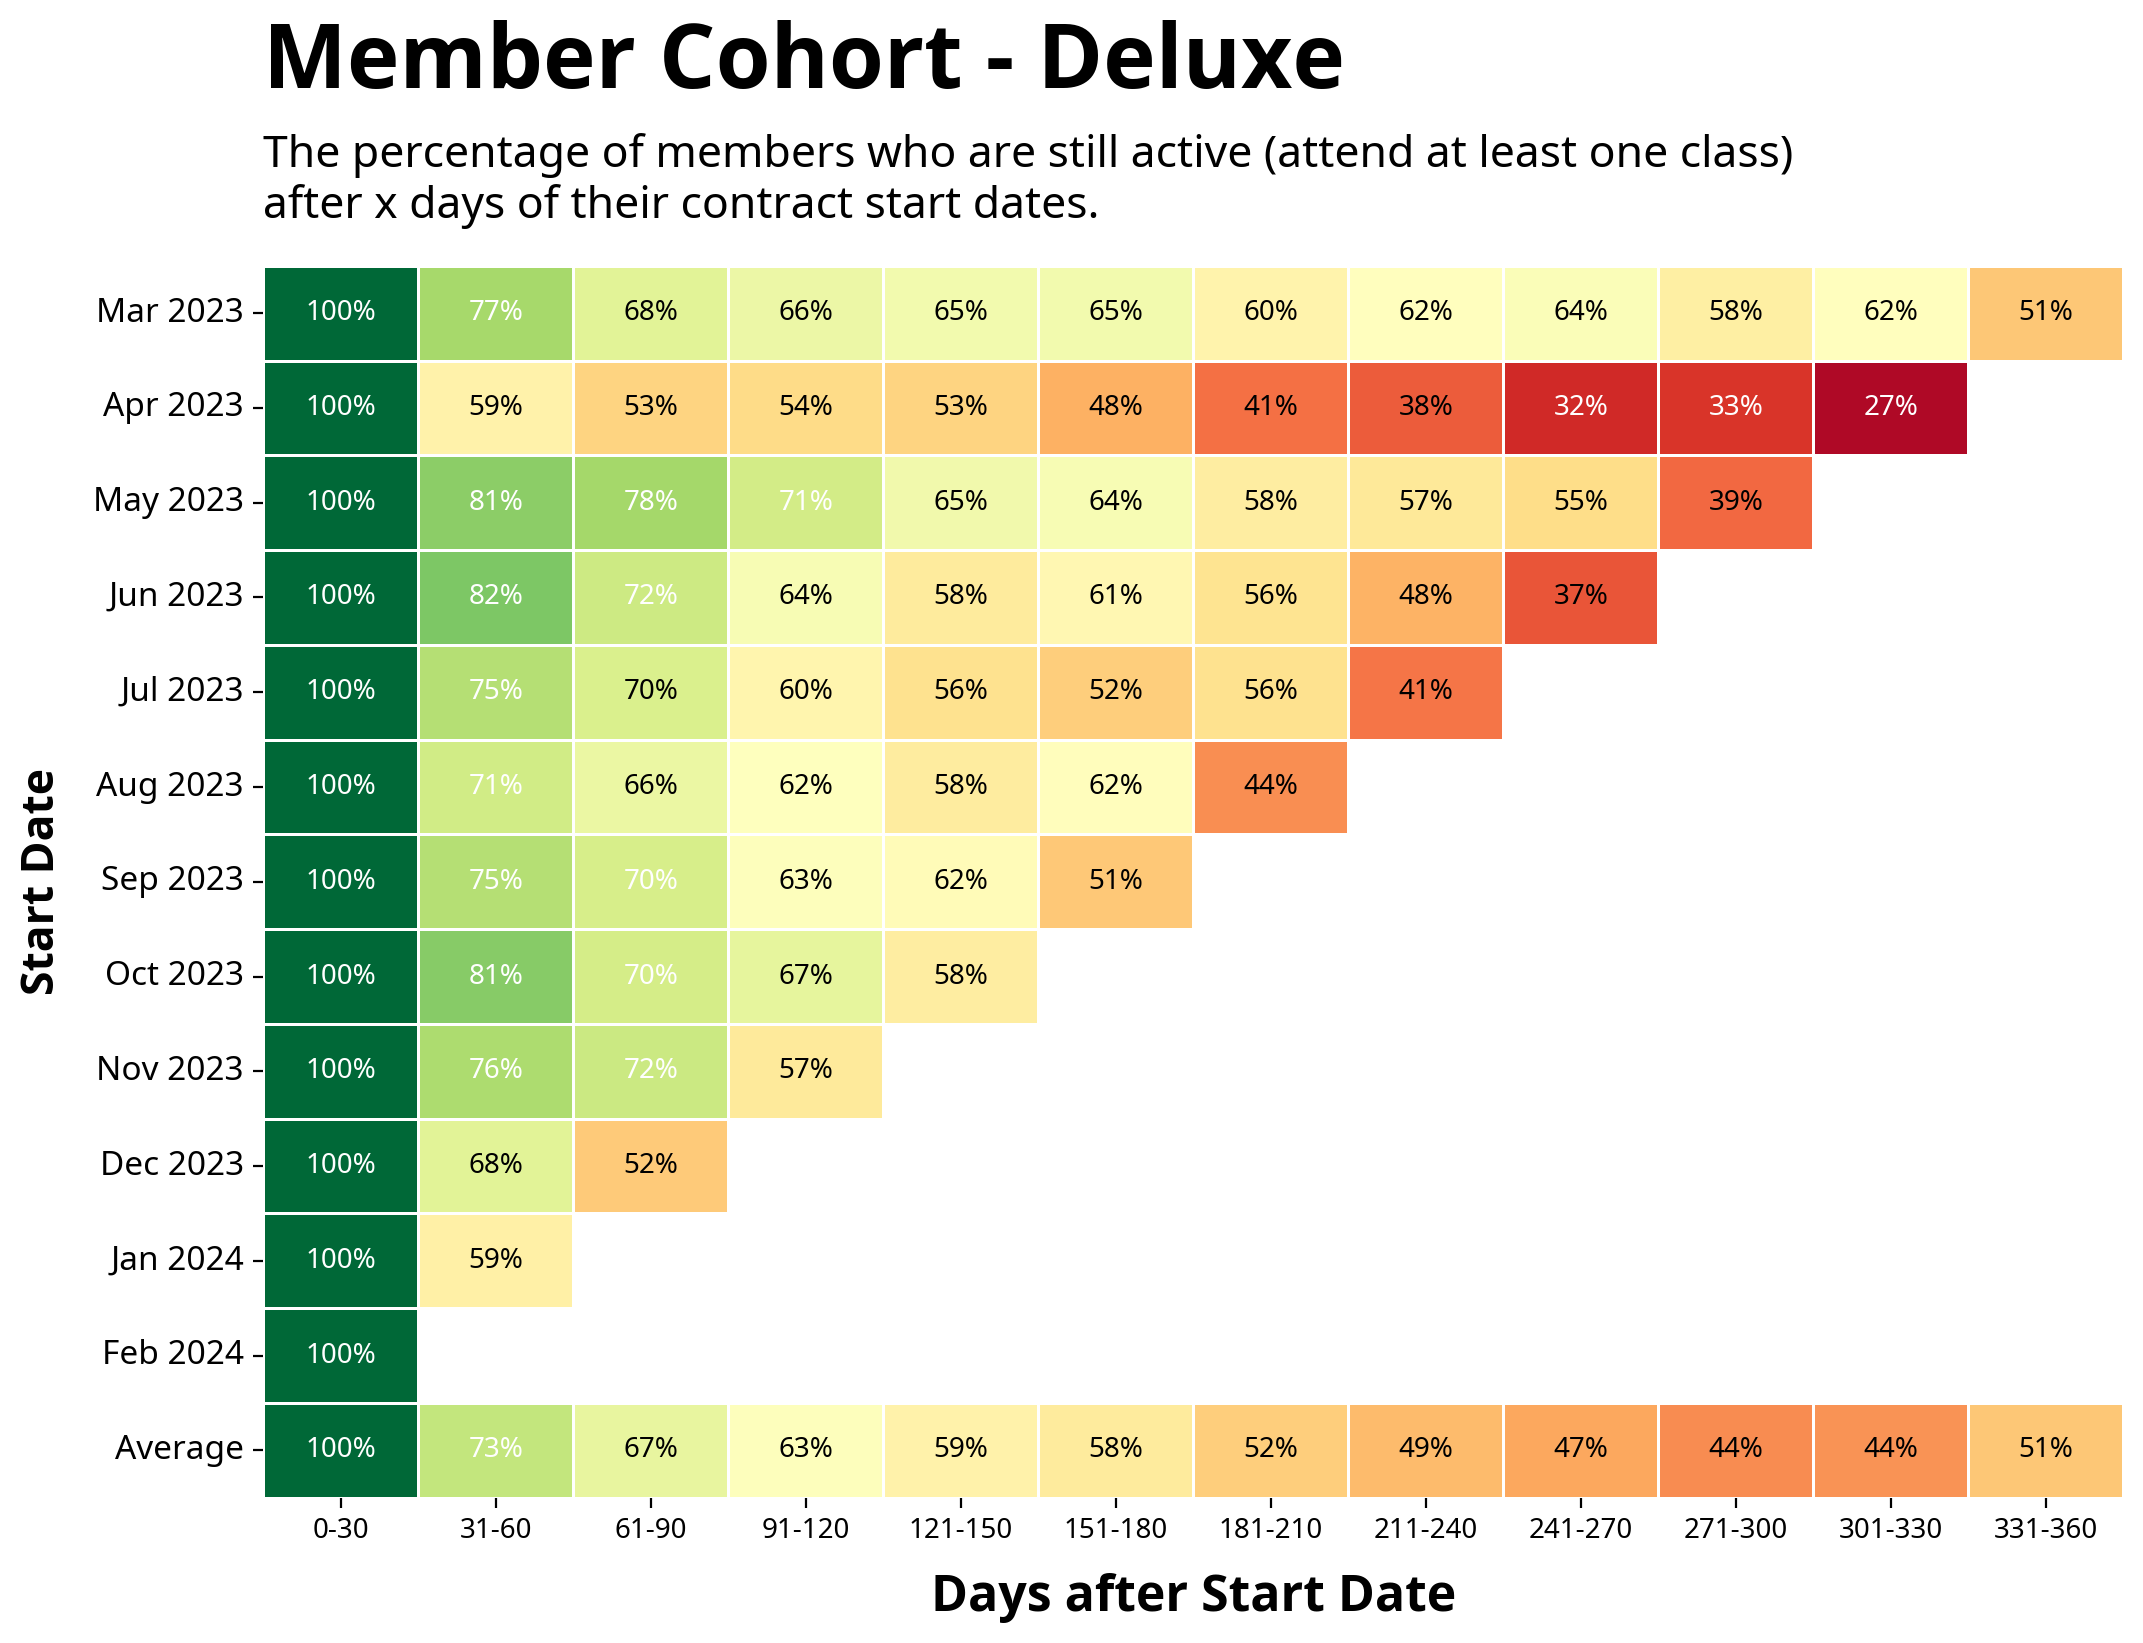

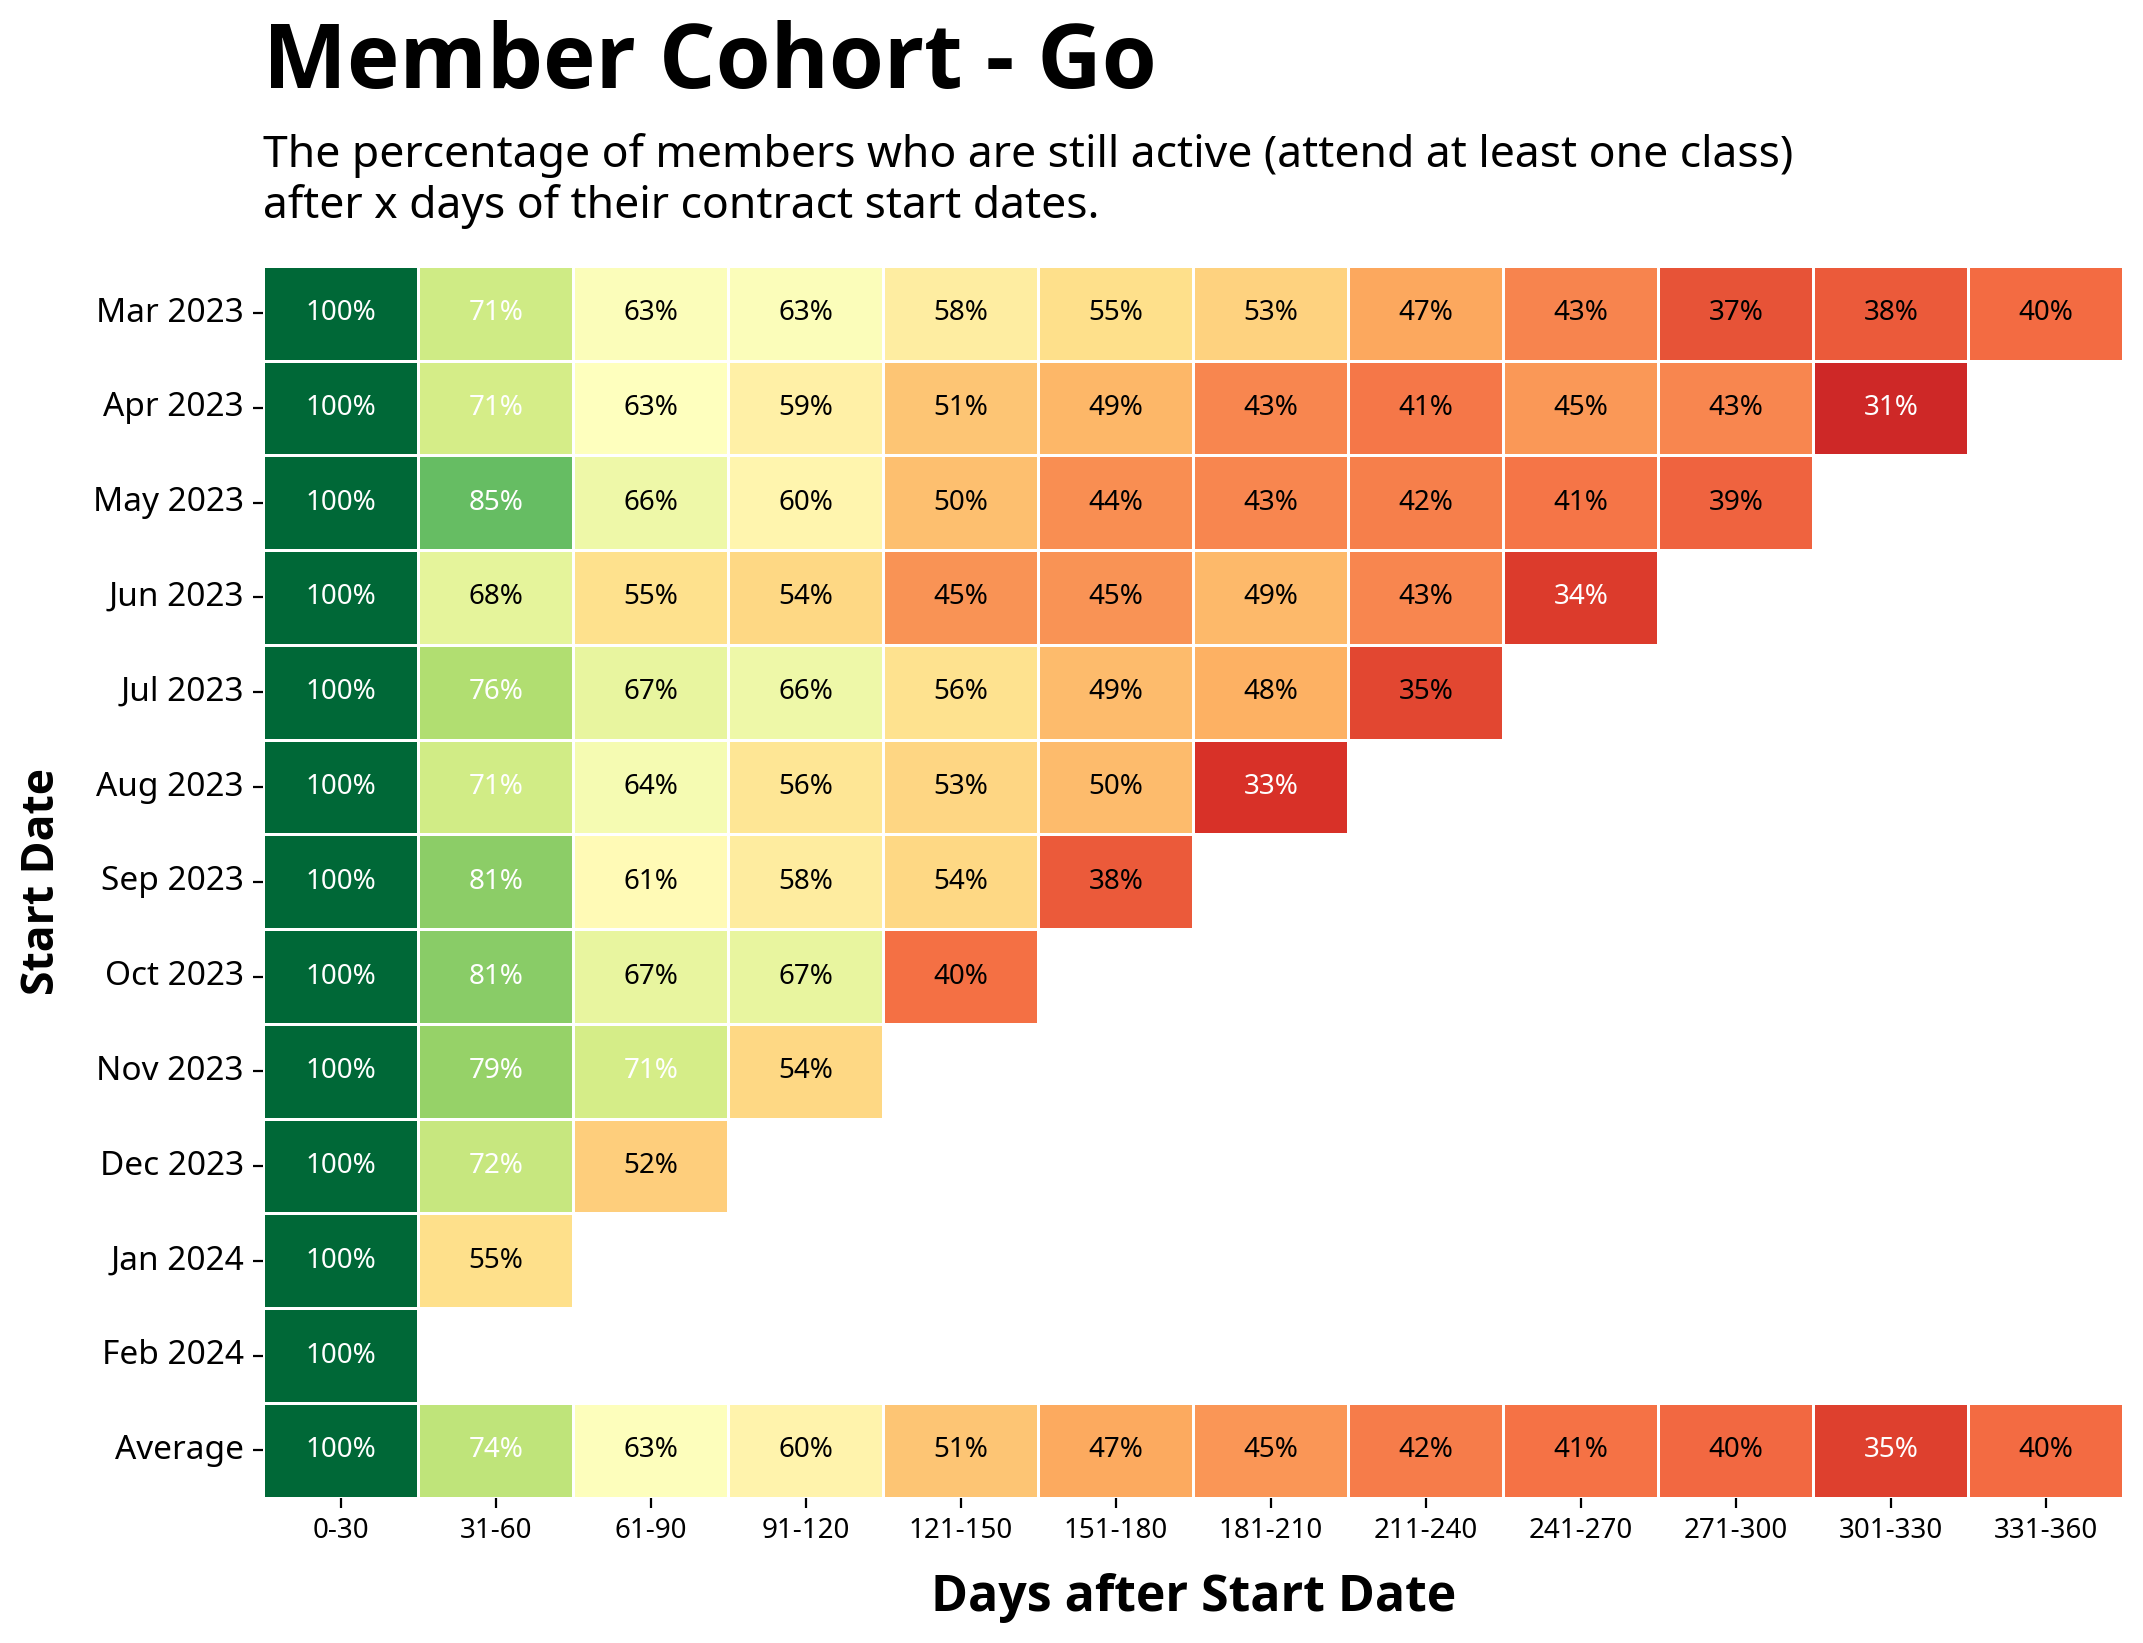

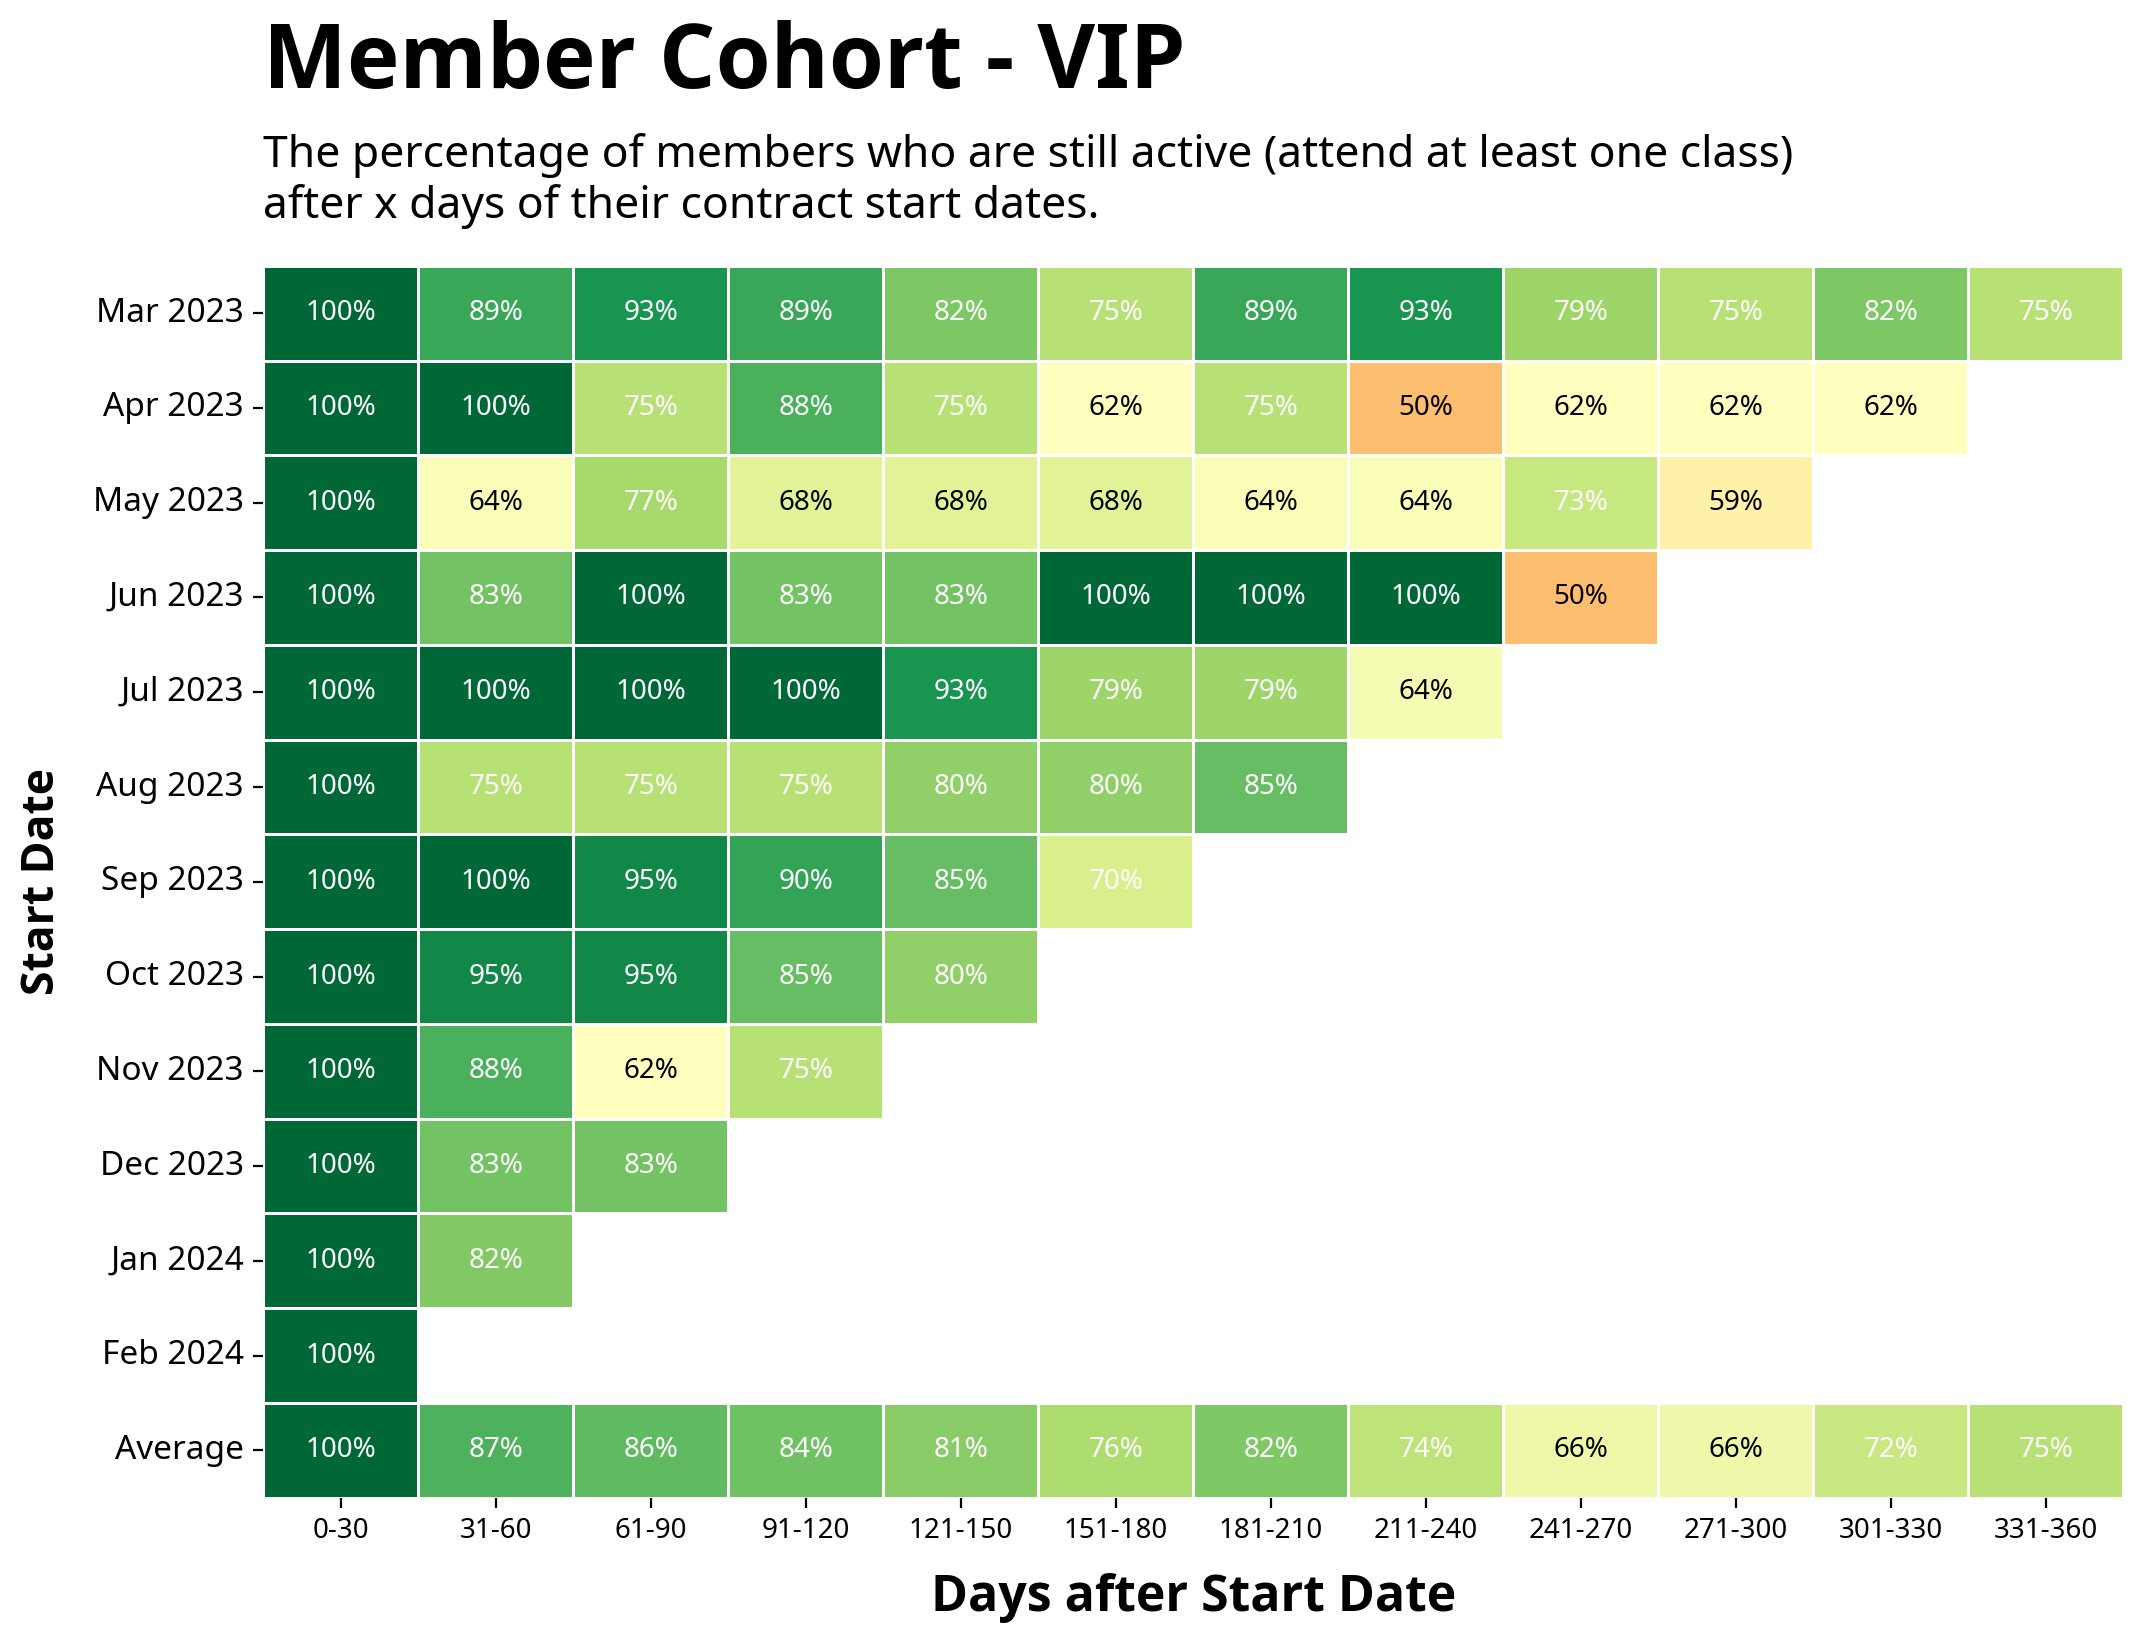

In [139]:
df_cohort_raw_membership = (
    df_cohort_raw
    .merge(
        right=df_coco_member.sort_values("start_date", ascending=True).drop_duplicates(subset=["student_code"]), 
        left_on="customer_id", 
        right_on="student_code", 
        how="left", 
        validate="many_to_one")
    .loc[:, ["customer_id", "transaction_date", "student_membership"]]
)

for membership in df_cohort_raw_membership["student_membership"].unique():
    df_cohort = module.make_cohort(df_cohort_raw_membership.loc[df_cohort_raw_membership["student_membership"] == membership])
    module.plot_cohort(df_cohort, title=f"Member Cohort - {membership}")

# 6: Center Population


## Population based on coco


In [72]:
# center_order = pd.CategoricalDtype(config.center_order, ordered=True)

In [73]:
# df_coco_pop = (df_coco_member
#     .assign(
#         # create activity for the current month
#         is_active = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 {config.month[3:]}"
#         ),
#         # get student center and area
#         student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
#         student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
#         consultant = lambda df_: df_["consultant"].str.title(),
#     )
#     # filter only active student
#     .loc[lambda df_: df_["is_active"] == True]
#     # group
#     .groupby(["student_area", "student_center", "student_membership"], observed=True)
#     .agg(
#         num_student=("student_code", "size")
#     )
#     # pivot
#     .reset_index()
#     .pivot(
#         index=["student_area", "student_center"],
#         columns="student_membership"
#     )
#     .sort_index(axis="rows", level=1)
#     .fillna(0)
#     .droplevel(0, axis="columns")
#     .rename_axis(["Area", "Center"], axis="rows")
#     .rename_axis([""], axis="columns")
# )
# df_coco_pop

In [74]:
# df_coco_pop_activity = (df_coco_member
#     .assign(
#         # create activity for the current month
#         is_active = lambda df_: module.is_active(
#             df_, "start_date", "end_date", f"1 {config.month[3:]}"
#         ),
#         # get student center and area
#         student_center = lambda df_: df_["student_center"].fillna("Not Specified").astype(center_order),
#         student_area = lambda df_: df_["student_area"].fillna("Not Specified"),
#         is_class_active=lambda df_: np.where(
#             df_["student_code"].isin((df_att.loc[df_att["student_attendance"] == "Attend", "student_code"].unique())),
#             "Class Active", "Class Inactive"
#         )
#     )
#     # filter only active student
#     .loc[lambda df_: df_["is_active"] == True]
#     # group
#     .groupby(["student_area", "student_center", "is_class_active"], observed=True)
#     .agg(
#         num_student=("student_code", "size")
#     )
#     # pivot
#     .reset_index()
#     .pivot(
#         index=["student_area", "student_center"],
#         columns="is_class_active"
#     )
#     .sort_index(axis="rows", level=1)
#     .fillna(0)
#     .droplevel(0, axis="columns")
#     .rename_axis(["Area", "Center"], axis="rows")
#     .rename_axis([""], axis="columns")
# )
# df_coco_pop_activity

## Population based on erwin


In [75]:
# df_erwin_pop = (df_erwin_member
#     # filter only active student and coco student
#     .loc[
#         (df_erwin_member[f"active_{config.month[3:].replace(' ', '_')}"] == True) &
#         ~(df_erwin_member["core_product"].isna())
#     ]
#     # cast center as categorical for ordering
#     .assign(
#         center=lambda df_: df_["center"].astype(center_order)
#     )
#     .groupby(["area","center", "core_product"], observed=True)
#     .agg(
#         num_student=("center", "count")
#     )
#     # pivot
#     .reset_index()
#     .pivot(
#         index=["area", "center"],
#         columns="core_product"
#     )
#     .sort_index(axis="rows", level=1)
#     .fillna(0)
#     .droplevel(0, axis="columns")
#     .rename_axis(["Area", "Center"], axis="rows")
#     .rename_axis([""], axis="columns")
# )
# df_erwin_pop

In [76]:
# TODO: add assertion that no members area, center and membership is na or not specified in config.center_order.sum().sum()

# Data: Class Mapping


In [77]:
df_class_mapping = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .assign(
        class_grouping=lambda df_: df_[
            "class_type_grouped"].map(module.class_grouping)
    )
    .groupby(["class_grouping", "class_mode", "class_type_grouped", "class_type"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=(
            "class_status", lambda c: (c == "Given").sum()),
    )
    .rename_axis(["Class Grouping", "Class Mode", "Class Type Grouped", "Class Type"])
    .rename(columns=lambda c: c.replace("_", " ").title())
)

# Save DF


In [81]:
path = (
    Path.cwd() /
    f"output/Exp Management Report (Source) - {config.month_noncoco}.xlsx"
)
sheets = {
    "Class Session & Utilization": class_session,
    "ET Utilization": et_util,
    "Community Class": df_comm_report,
    "Community Class 2": df_comm_report_2,
    # 'Member Pop Erwin': df_erwin_pop,
    # 'Member Pop Coco': df_coco_pop,
    # 'Member Pop Coco - Activity': df_coco_pop_activity,
    "Ooolab": ooolab.reset_index(),
    "Data - Session": df_sess_full,
    "Data - Class Mapping": df_class_mapping,
    "Data - Community Session": df_comm,
}

if not os.path.exists(path):
    module.save_multiple_dfs(dfs, path)
    print("File saved.")
else:
    print("File already exist.")

File already exist.


# Experiment


In [ ]:
# teachers = [
#     "Algar Sinclair Alexander John",
#     "Handayani Khaerunisyah Risma",
#     "Johanson Brian",
#     "Jurado Michael John",
#     "Quezada Amir Benveniste",
#     "Lee Platel Connor",
#     "Mowatt Peter Denis",
#     "Pratama Dimas Indra",
#     "Jones Jack William Isaac",
#     "Pakpahan Ruth Olivia Angelina",
#     "Oktavia Cindy",
#     "Fairuz Muhammad",
#     "Khalisa Fairuz Putri",
#     "Murti Gitasya",
# ]
# for teacher in teachers:
#     result = (df_sess_full
#         .loc[df_sess_full['teacher'] == teacher, ['class_date', 'class_time', 'class_duration']]
#         .drop_duplicates()
#         .assign(class_hour= lambda df_: df_['class_time'].astype(str).str[:2])
#         .groupby('class_date')
#         .agg(
#             class_hour= ('class_hour', lambda x: ', '.join(x)),
#             total_hours= ('class_duration', 'sum')
#         )
#         .loc[lambda df_: df_['total_hours'] <= 6]
#         .reset_index()
#         .assign(
#                 class_date=lambda df_: df_["class_date"].dt.strftime("%d %b"),
#                 total_hours=lambda df_: df_["total_hours"].astype(int)
#         )
#     )
#     print(teacher)
#     print(result.to_markdown(), end="\n\n")